# Home Credit Default Risk

# Library used

In [395]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [396]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [397]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [398]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

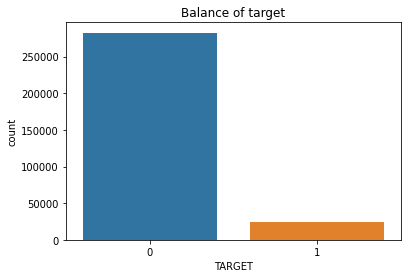

In [399]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

The data is very unbalanced.

## Gender distribution

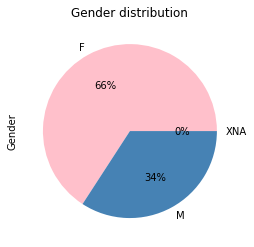

In [400]:
gender_group = app_train.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

### Contract type distribution

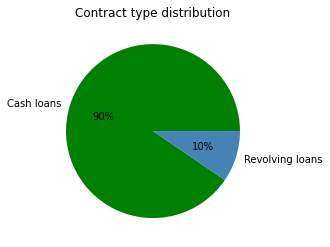

In [401]:
contract_group = app_train.groupby(['NAME_CONTRACT_TYPE'])
contract_group.size().plot(kind='pie', 
                           ylabel='', 
                           colors=['green', 'steelblue'], 
                           title='Contract type distribution',
                           autopct='%.0f%%')
plt.show()

## Days Birth feature

### Informations

In [402]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [403]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 20.517808219178082 days
Days birth max : 69.12054794520547 years


### Boxplots

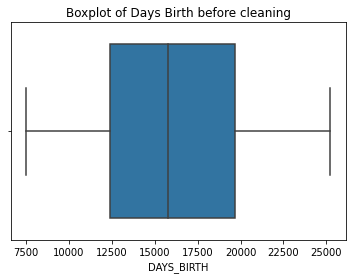

In [404]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Missing values

In [405]:
print("30 first columns filled with the most NaN values with their percentage:")
((app_train.isnull().sum()/app_train.shape[0])*100).sort_values(ascending=False).head(30)

30 first columns filled with the most NaN values with their percentage:


COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MEDI              67.848630
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_MODE            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_AVG                59.376738
LANDAREA_MODE               59.376738
LANDAREA_MEDI               59.376738
BASEMENTAREA_MODE           58.515956
BASEMENTAREA_MEDI           58.515956
BASEMENTAREA_AVG            58.515956
EXT_SOURCE_1                56.381073
NONLIVINGAREA_AVG           55.179164
NONLIVINGAREA_MODE          55.179164
NONLIVINGARE

# Data cleanup 

## Label encoding

In [406]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Missing and infinite values

In [407]:
# Replacing Infinite values with NaN values
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [408]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_train)
imputer = imputer.fit_transform(app_train)
app_train = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())

In [409]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_test)
imputer = imputer.fit_transform(app_test)
app_test = pd.DataFrame(imputer, columns = app_test.columns.values.tolist())

## Days Employed feature

### Informations 

In [410]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [411]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "years" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 years
Days employed max : 49.07397260273972 years


We can see an anomaly : the biggest 'Days Employed' value is around 1000 years !

### Boxplots

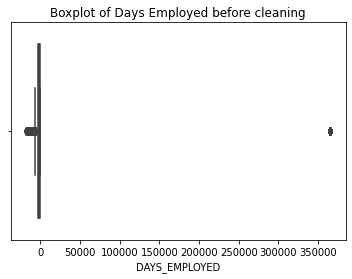

In [412]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

### Removing anomalies

In [413]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

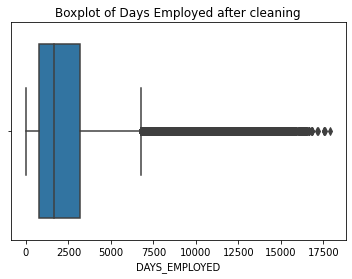

In [414]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

# Making our model

## Correlations

In [415]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n\n', correlations.tail(15))
print('\nMost Negative Correlations:\n\n', correlations.head(15))

Most Positive Correlations:

 DAYS_ID_PUBLISH                0.039910
WALLSMATERIAL_MODE             0.040758
FLAG_DOCUMENT_3                0.041272
REG_CITY_NOT_LIVE_CITY         0.041977
REG_CITY_NOT_WORK_CITY         0.043384
HOUSETYPE_MODE                 0.043432
EMERGENCYSTATE_MODE            0.045183
CODE_GENDER                    0.049185
DAYS_LAST_PHONE_CHANGE         0.060288
REGION_RATING_CLIENT           0.065113
DAYS_BIRTH                     0.065756
NAME_EDUCATION_TYPE            0.065911
REGION_RATING_CLIENT_W_CITY    0.067458
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:

 EXT_SOURCE_2                 -0.170339
EXT_SOURCE_3                 -0.155930
EXT_SOURCE_1                 -0.099359
AMT_GOODS_PRICE              -0.050306
FLOORSMAX_AVG                -0.043890
FLOORSMAX_MEDI               -0.043611
FLOORSMAX_MODE               -0.042756
AMT_CREDIT                   -0.04065

# Splitting data into train and validation

In [416]:
Xdf = app_train
Xdf.drop("TARGET", axis = 1)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

In [417]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

## Model training

In [418]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Model testing

In [419]:
y_pred = model.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 0. 0. ... 0. 0. 0.] 

Real values:

 [0. 1. 1. ... 0. 0. 0.]


## Model evaluation

### Confusion matrix

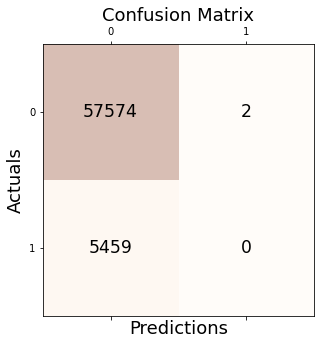

The confusion matrix shows us the number of :

* True positives : 57574 

* True negatives : 2 

* False positives: 5459 

* False negatives: 0 



In [420]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:',conf_matrix[1][0] ,'\n')
print('* False negatives:',conf_matrix[1][1] ,'\n')

In [421]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     57576
         1.0       0.00      0.00      0.00      5459

    accuracy                           0.91     63035
   macro avg       0.46      0.50      0.48     63035
weighted avg       0.83      0.91      0.87     63035



### Accuracy Score

In [422]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 91.34 %

Accuracy score using cross validation: 91.34 %



Model accuracy is a machine learning model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations.

The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

### Precision Score

In [423]:
print("Precision score:", round((precision_score(y_test, y_pred, average='macro')*100), 2), '%\n')

Precision score: 45.67 %



The precision score is a useful measure of the success of prediction when the classes are very imbalanced.

Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

### Recall Score

In [424]:
print("Recall score:", round((metrics.recall_score(y_test, y_pred)*100), 2), '%\n')

Recall score: 0.0 %



Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made.

Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

### F1 Score

In [425]:
metrics.f1_score(y_test, y_pred)

0.0

F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

### ROC Curve

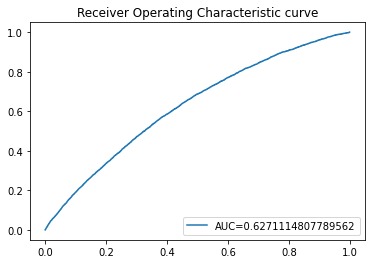

In [426]:
prediction_prob = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.